In [19]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil
import matplotlib.pyplot as plt

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [20]:
#Identify experiments that are not in the ignore list 
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

ignore_list = [".csv",
               "ipynb",
                "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
#                "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
               "human",
#                "GPT_P",
#                "exp2_R"
#                "llm",
#                "exp1",
#                "report", 
#                "covariates",
               
]

experiments_include = []

for experiment_name in os.listdir(f"{directory}{'Full_Report'}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments_include.append(experiment_name)

experiments_include

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
 'ag_local_DeepARModel',
 'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
 'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',


In [21]:

report_sim_dates = open("../generate_forecasts/experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:1]


target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
#      'Food purchased from restaurants',
#      'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]

llmp_target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Meat',
     'Vegetables and vegetable preparations'
]


### Remove once it is finished running
report_sim_dates= [report_sim_dates[0]]
target_categories = target_categories[0:2]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
Report Simulation Dates:
2018-07-01


### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

In [22]:
# # Define the source directory (starting from Full_Report)
# source_dir = "../generate_forecasts/output/Full_Report/"
# # No need to hard-code the destination directory here; it will be determined dynamically

# # Walk through the source directory to find the directories that contain '2024-07-01'
# for experiment in os.listdir(source_dir):
#     if experiment in experiments_include:
#         print(experiment)
        
#         for root, dirs, files in os.walk(f"/h/kupfersk/cfpr_2025/generate_forecasts/output/Full_Report/{experiment}"):
#             # Determine the destination directory dynamically by replacing 'Full_Report' with 'Forecasts'
#             new_dest = root.replace("Full_Report", "Experimental_Analysis")

#             # Ensure the destination directory exists, if not, create it
#             os.makedirs(new_dest, exist_ok=True)

#             # Move all files from the current 'root' to the new destination directory
#             for file in files:
#                 if '.csv' in file:
#                     source_file = os.path.join(root, file)
#                     dest_file = os.path.join(new_dest, file)
#                     shutil.copy2(source_file, dest_file)  # Use shutil.move() to move files
#                     print(f"Moved {source_file} to {dest_file}")


### Define evaluation metrics and calculate mape for all periods

In [23]:
# Define the source directory (starting from Full_Report)
source_dir = "../generate_forecasts/output/Experimental_Analysis/"
experiments = experiments_include
experiments

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
 'ag_local_DeepARModel',
 'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
 'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',


In [24]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [25]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    
        
#     # Load the dictionary from the JSON file
#     with open('target_category_dict_filt.json', 'r') as json_file:
#         target_category_dict = json.load(json_file)
        
    for start_year in start_years:
        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                predicted_categories = target_categories
#                 if "R" not in EXPERIMENT_NAME:
#                     if 'exp' in EXPERIMENT_NAME: 
#                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
#                         predicted_categories_in = target_category_dict[general_experiment]

                        # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
#                         predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']


            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)


In [26]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [27]:
## For classical model experiments 
mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

# mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"
mape_df.experiment.unique()


ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_
ag_local_DeepARModel
ag_global_all_SimpleFeedForwardModel_exp2_R4_
ag_global_all_TemporalFusionTransformerModel_exp2_R3_
ag_global_all_SimpleFeedForwardModel_exp2_R1_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel
gemini-1.5-pro_report_True_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_
ag_local_AutoETSModel
gemini-1.5-pro_report_False_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_
ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_
claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_
ag_global_all_PatchTSTModel
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_
ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_
gemini-1.5

array(['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
       'ag_local_DeepARModel',
       'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
       'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
       'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
       'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
       'ag_local_AutoETSModel',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
       'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
       'ag_global_all_PatchTSTModel',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
       'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_',
       'ag_global_all_SimpleFeedFor

### Lookup which variables were selected by each method

In [28]:
base_dir = '/h/kupfersk/cfpr_2025/cfpr_variable_selection/select_lists'
all_experiments = os.listdir(base_dir)

keep_list = [
    "8_",
    "llm_ind",
    "GPT_P",
    "climate",
    "economic",
    "manufacturing",
    "geopolitical",
]

experiments_include = []

for experiment_name in all_experiments:
    # Use `any` to check if any keyword is in the experiment name
    if any(keyword in experiment_name for keyword in keep_list):
        experiments_include.append(experiment_name)

experiments_include

['8_bakery.txt',
 '8_fish.txt',
 'llm_ind_dairy.txt',
 'economic.txt',
 'GPT_P3.txt',
 'GPT_P1.txt',
 'geopolitical.txt',
 'llm_ind_fruit.txt',
 '8_meat.txt',
 'GPT_P2.txt',
 'llm_ind_meat.txt',
 'llm_ind_bakery.txt',
 'GPT_P4.txt',
 'llm_ind_vegetables.txt',
 'llm_ind_fish.txt',
 '8_dairy.txt',
 '8_vegetables.txt',
 '8_fruit.txt',
 'climate.txt',
 'manufacturing.txt']

In [29]:

# Initialize an empty DataFrame and an empty list to store features
df = pd.DataFrame()
features_used_all = []

# Iterate through each experiment
for experiment in experiments_include:
    # Define the path to the .txt file for each experiment
    file_path = os.path.join(base_dir, experiment)
    
    # Read in features from the .txt file
    try:
        with open(file_path, 'r') as file:
            exogenous_variables = file.read().splitlines()  # Assumes each feature is on a new line
    except FileNotFoundError:
        print(f"File not found for experiment: {experiment}")
        continue
    
    # Create a temporary DataFrame with the current experiment's data
    temp_df = pd.DataFrame({
        'experiment': [experiment],
        'features_used': [exogenous_variables]
    })
    
    # Concatenate the temporary DataFrame with the main DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)
    
    # Add the features to the list for all experiments
    features_used_all.append(exogenous_variables)

# Optionally reset the index of the DataFrame for cleaner viewing
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df

,experiment,features_used
0,8_bakery.txt,"[apu000072610, excaus, fmpi, impch, impmx, pcu..."
1,8_fish.txt,"[apu000072610, cwur0000sa0, fmpi, impch, impmx..."
2,llm_ind_dairy.txt,"[pcu32533253, pcu325311325311, fppi_total, mil..."
3,economic.txt,"[apu000072610, cwur0000sa0, excaus, fedfunds, ..."
4,GPT_P3.txt,"[policy_uncertainty, excaus, fmpi, pcu32533253..."
5,GPT_P1.txt,"[excaus, fmpi, pcu32533253, pcu325311325311, w..."
6,geopolitical.txt,"[policy_uncertainty, excaus, impca, impch, imp..."
7,llm_ind_fruit.txt,"[excaus, pcu32533253, wtisplc, enso, energy_cp..."
8,8_meat.txt,"[apu000072610, cwur0000sa0, fmpi, impch, impmx..."
9,GPT_P2.txt,"[excaus, pcu32533253, pcu325311325311, wtisplc..."


In [30]:

def assign_category(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'bakery' in experiment:
        return 'Bakery'
    
   # Check for LLM models (Chronos in this case)
    elif 'fish' in experiment:
        return 'Fish'
    
    # Check for LLM models (Chronos in this case)
    elif 'meat' in experiment:
        return 'Meat'

    # Check for LLM models (Chronos in this case)
    elif 'other' in experiment:
        return 'Other'

    # Check for general deep learning models
    elif 'restaurant' in experiment:
        return 'Restaurant'
    
    # Check for general deep learning models
    elif 'veg' in experiment:
        return 'Vegetables'
    
    # Check for general deep learning models
    elif 'fruit' in experiment:
        return 'Fruit'
    
    # Check for general deep learning models
    elif 'dairy' in experiment:
        return 'Dairy'
    
    # Check for general deep learning models
    elif 'overall' in experiment:
        return 'Overall'
    
    # Check for general deep learning models
    else:
        return 'General - Non category specific'
    
        
def assign_selection(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if '8_' in experiment:
        return 'Baseline - Correlation by category'
    
   # Check for LLM models (Chronos in this case)
    elif 'llm_ind' in experiment:
        return 'Baseline - LLM no persona by category'
    
    # Check for LLM models (Chronos in this case)
    elif 'gpt_p1' in experiment:
        return 'Geopolitical - LLM persona Global affairs specialist'

    # Check for LLM models (Chronos in this case)
    elif 'gpt_p2' in experiment:
        return 'Economic - LLM persona Economist'

    # Check for general deep learning models
    elif 'gpt_p3' in experiment:
        return 'Climate - LLM persona Agronomist'
    
    # Check for general deep learning models
    elif 'gpt_p4' in experiment:
        return 'Baseline - LLM persona average Canadian'
    
    # Check for general deep learning models
    elif 'climate' in experiment:
        return 'Climate - Human suggested - climate'
    
    # Check for general deep learning models
    elif 'economic' in experiment:
        return 'Economic - Human suggested economic'
    
    # Check for general deep learning models
    elif 'geopolitical' in experiment:
        return 'Geopolitical - Human suggested geopolitical'
    
    # Check for general deep learning models
    elif 'manufacturing' in experiment:
        return 'Economic - Human suggested manufacturing'
    
def assign_group(selection):
    selection = selection.lower()  # Convert to lowercase for case-insensitive matching
    
    # Check for general deep learning models
    if 'climate' in selection:
        return 'Climate'
    
    # Check for general deep learning models
    elif 'economic' in selection:
        return 'Economic'
    
    # Check for general deep learning models
    elif 'geopolitical' in selection:
        return 'Geopolitical'
    
    # Check for general deep learning models
    elif 'baseline' in selection:
        return 'Baseline'
      
    
# Apply the function to add a new column 'condition' in filt_df

df['selection'] = df['experiment'].apply(assign_selection)
df['category'] = df['experiment'].apply(assign_category)
df['group'] = df['selection'].apply(assign_group)


df['category'].unique()

array(['Bakery', 'Fish', 'Dairy', 'General - Non category specific',
       'Fruit', 'Meat', 'Vegetables'], dtype=object)

In [31]:
df

,experiment,features_used,selection,category,group
0,8_bakery.txt,"[apu000072610, excaus, fmpi, impch, impmx, pcu...",Baseline - Correlation by category,Bakery,Baseline
1,8_fish.txt,"[apu000072610, cwur0000sa0, fmpi, impch, impmx...",Baseline - Correlation by category,Fish,Baseline
2,llm_ind_dairy.txt,"[pcu32533253, pcu325311325311, fppi_total, mil...",Baseline - LLM no persona by category,Dairy,Baseline
3,economic.txt,"[apu000072610, cwur0000sa0, excaus, fedfunds, ...",Economic - Human suggested economic,General - Non category specific,Economic
4,GPT_P3.txt,"[policy_uncertainty, excaus, fmpi, pcu32533253...",Climate - LLM persona Agronomist,General - Non category specific,Climate
5,GPT_P1.txt,"[excaus, fmpi, pcu32533253, pcu325311325311, w...",Geopolitical - LLM persona Global affairs spec...,General - Non category specific,Geopolitical
6,geopolitical.txt,"[policy_uncertainty, excaus, impca, impch, imp...",Geopolitical - Human suggested geopolitical,General - Non category specific,Geopolitical
7,llm_ind_fruit.txt,"[excaus, pcu32533253, wtisplc, enso, energy_cp...",Baseline - LLM no persona by category,Fruit,Baseline
8,8_meat.txt,"[apu000072610, cwur0000sa0, fmpi, impch, impmx...",Baseline - Correlation by category,Meat,Baseline
9,GPT_P2.txt,"[excaus, pcu32533253, pcu325311325311, wtisplc...",Economic - LLM persona Economist,General - Non category specific,Economic


In [32]:
# Flatten features_used_all and get unique values
unique_features = set(feature for sublist in features_used_all for feature in sublist)

# Convert to a list if you prefer a list format instead of a set
unique_features = list(unique_features)

unique_features

['fppi_total',
 'pcu324191324191',
 'excaus',
 'rmpi_total',
 'energy_cpi',
 'pcu482111482111',
 'commodity_food',
 'pdsi_total',
 'cwur0000sa0',
 'unratensa',
 'canola_oil',
 'apu000072610',
 'fmpi',
 'swe_total',
 'pcu325311325311',
 'impmx',
 'irltlt01cam156n',
 'milk_sold_total',
 'policy_uncertainty',
 'wtisplc',
 'pcu32533253',
 'impca',
 'commodity_fertilizer',
 'paynsa',
 'enso',
 'work_stop_total',
 'fedfunds',
 'impch',
 'pcu333132333132',
 'recprousm156n']

In [33]:
#Categories to compare
categories_compare = [
    'Bakery',
    'Fish',
    'Fruit'
    'Meat',
    'Vegetables'
    'Dairy'
]

In [34]:
df = df.sort_values(by='selection')

In [35]:
# Mapping dictionary based on the provided table
column_mapping = {
    "policy_uncertainty": "Economic Policy Uncertainty Index",
    "apu000072610": "Average price of electricity in U.S. cities",
    "cwur0000sa0": "All Items CPI (U.S.)",
    "excaus": "USD-CAD exchange rate",
    "fedfunds": "Federal Funds Effective Rate (U.S.)",
    "fmpi": "Food manufacturing price index (U.S.)",
    "impca": "U.S. imports from Canada",
    "impch": "U.S. imports from China",
    "impmx": "U.S. imports from Mexico",
    "irltlt01cam156n": "Interest rates",
    "paynsa": "Total U.S. employees (Non-farm)",
    "pcu32533253": "Pesticide and fertilizer production price index (U.S.)",
    "pcu324191324191": "Petroleum oil and grease production price index (U.S.)",
    "pcu325311325311": "Nitrogenous fertilizer production price index (U.S.)",
    "pcu333132333132": "Oil and gas machinery production price index (U.S.)",
    "pcu482111482111": "Line haul railroads production price index (U.S.)",
    "recprousm156n": "U.S. Recession Probabilities",
    "unratensa": "U.S. Unemployment Rate",
    "wtisplc": "Crude Oil Price",
    "enso": "El Niño-Southern Oscillation (ENSO)",
    "canola_oil": "Canola oil production",
    "energy_cpi": "Energy CPI",
    "swe_total": "Snow Water Equivalent (SWE)",
    "pdsi_total": "Palmer Drought Severity Index (PDSI)",
    "fppi_total": "Farm product price index",
    "milk_sold_total": "Milk sold off farms",
    "work_stop_total": "Number of work stoppages (All industries)",
    "rmpi_total": "Raw materials price index",
    "commodity_food": "Food commodity price index",
    "commodity_fertilizer": "Fertilizer commodity price index"
}

### Plot all together

NameError: name 'group' is not defined

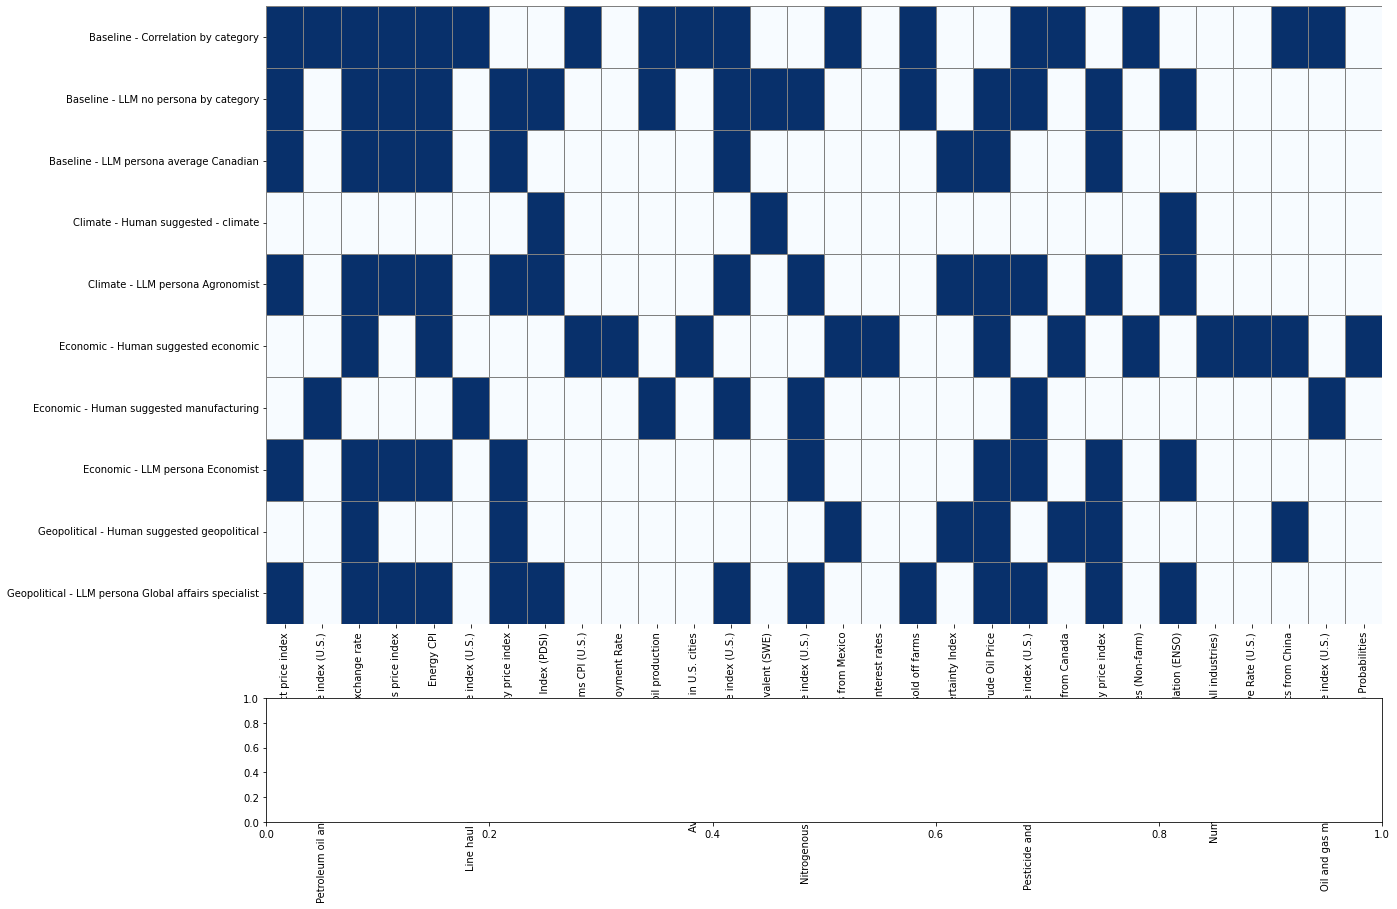

In [37]:
import seaborn as sns

filtered_df = df

# Populate the dictionary: group features by selection and set 1 if used in the experiment
group_feature_matrix_dict = {}
for selection in filtered_df['selection'].unique():
    selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
    group_feature_matrix_dict[selection] = [1 if feature in selection_features else 0 for feature in unique_features]

# Convert to DataFrame for heatmap plotting
feature_matrix = pd.DataFrame(group_feature_matrix_dict, index=unique_features)

# Rename rows for readability based on the column_mapping dictionary
feature_matrix.rename(index=column_mapping, inplace=True)

# Calculate frequency of each feature for the second heatmap
feature_counts = feature_matrix.sum(axis=1)
feature_count_df = pd.DataFrame(feature_counts, columns=['Frequency'])

# Find the maximum frequency
max_frequency = feature_count_df['Frequency'].max()

# Set up a combined figure with vertically stacked heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), gridspec_kw={'height_ratios': [5, 1]})

# Heatmap 1: Feature Usage by Selection (Blue color scale) - without color bar
sns.heatmap(
    feature_matrix.T, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor='grey', 
    annot=False, 
    cbar=False,  # Remove color bar
    ax=ax1
)
ax1.set_title(f"Feature Curation Comparison - {group} Variables", fontsize=22, weight='bold')
ax1.set_xlabel("")  # Remove x-axis label for upper heatmap
ax1.set_ylabel("Selection", fontsize=18)
ax1.tick_params(axis='x', bottom=False)  # Hide x-tick marks
ax1.set_xticklabels([])  # Remove x-tick labels

# Heatmap 2: Frequency of Feature Usage (Green color scale) - without color bar
sns.heatmap(
    feature_count_df.T, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor='grey', 
    annot=True, 
    fmt="d", 
    annot_kws={'size': 14}, 
    cbar=False,  # Remove color bar
    ax=ax2
)
ax2.set_title("Overall Frequency of Feature Selection", fontsize=16, weight='bold')
ax2.set_xlabel("Unique Features", fontsize=18)
ax2.set_ylabel("")  # Remove y-axis label for lower heatmap
ax2.tick_params(axis='x', rotation=45, labelsize=14)

# Bold x-tick labels where frequency is maximum
x_labels = feature_count_df.index
ax2.set_xticks(range(len(x_labels)))  # Ensure tick positions align
ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# Apply bold font weight to labels with maximum frequency
for label, frequency, tick in zip(x_labels, feature_count_df['Frequency'], ax2.get_xticklabels()):
    if frequency == max_frequency:
        tick.set_fontweight('bold')  # Bold only the labels with max frequency

plt.tight_layout()
plt.savefig(f'Preprint_overall_selection.pdf')
plt.show()

### Plot individually by group for easy visualization

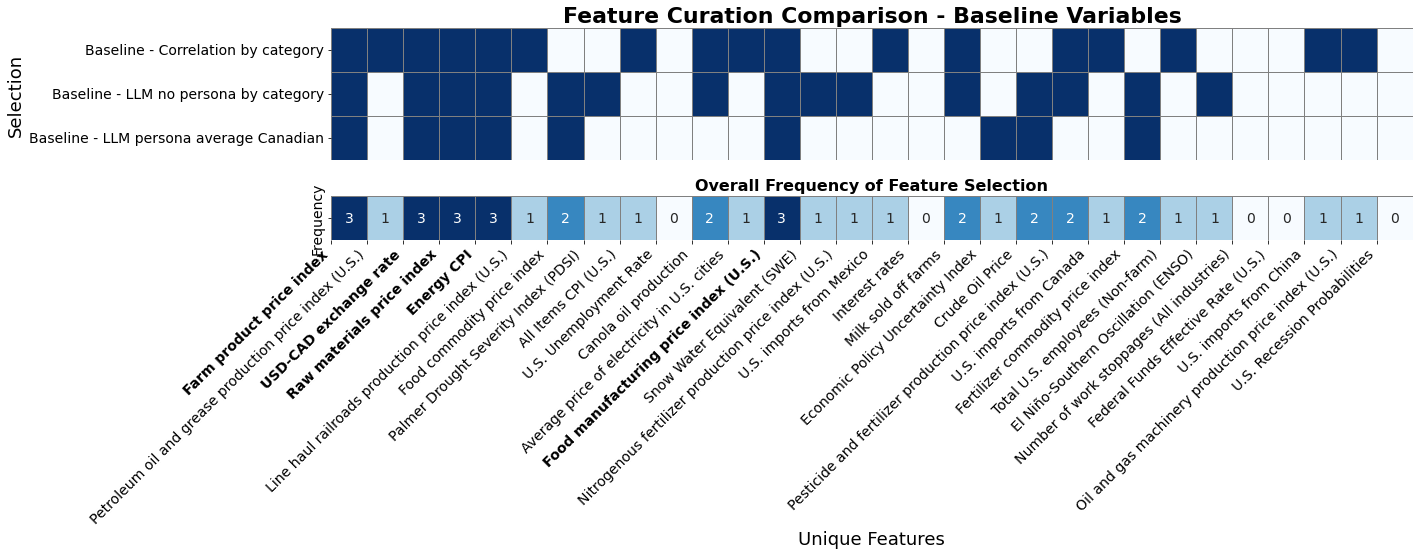

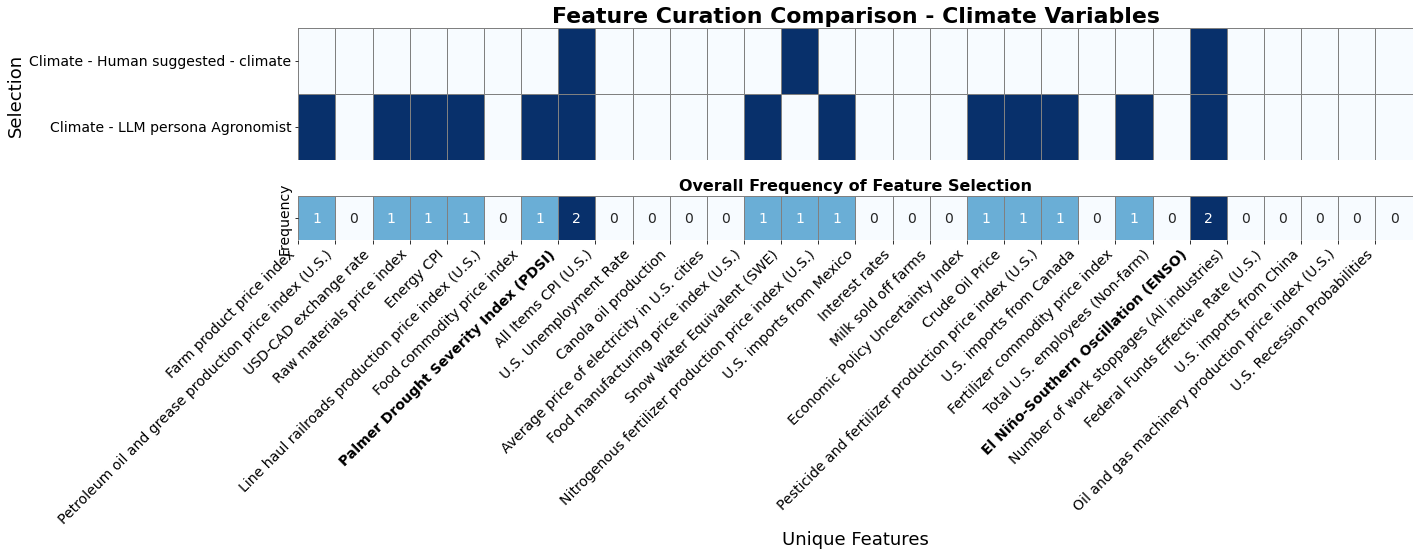

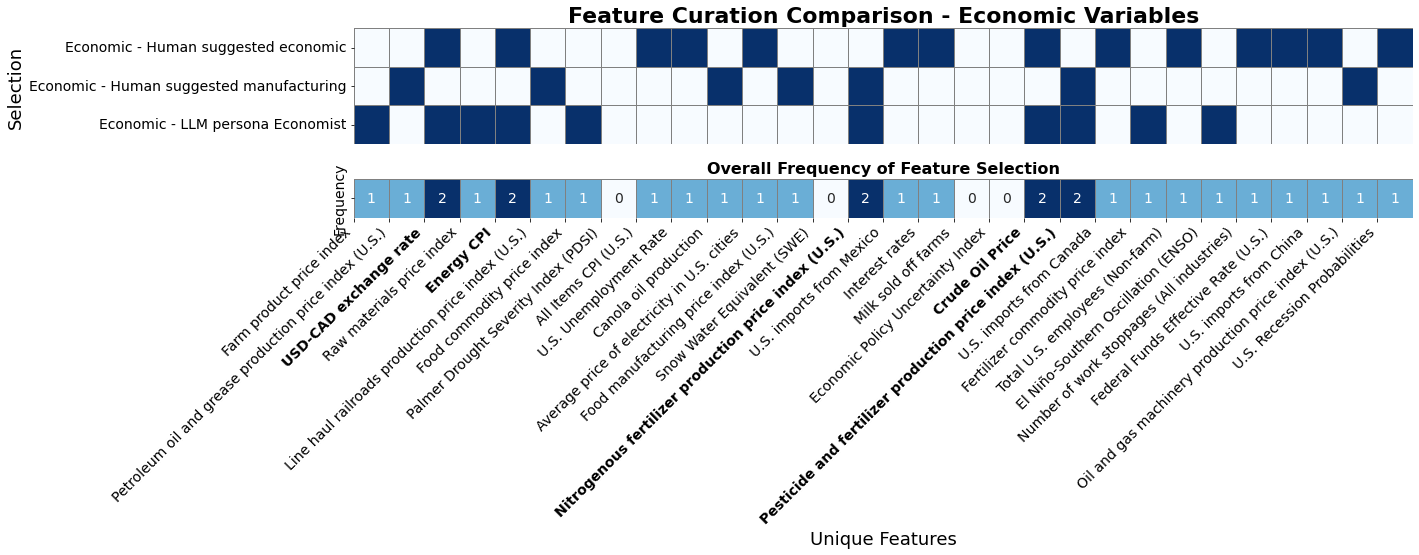

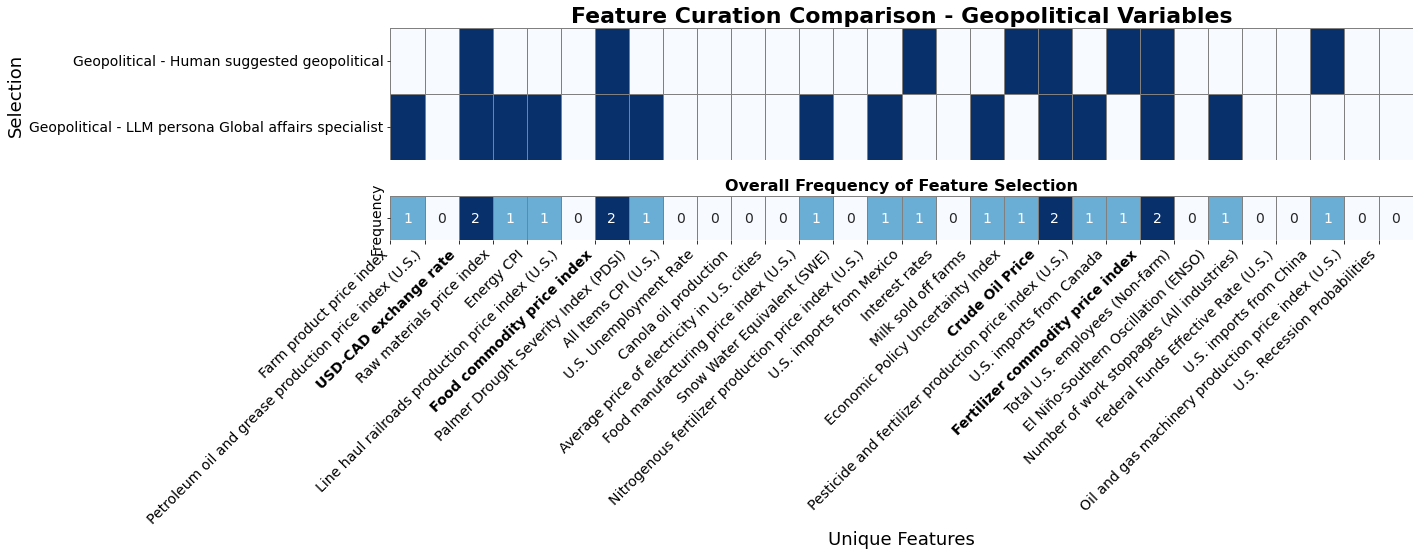

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set general font properties for readability
plt.rcParams.update({
    'font.size': 16,  # General font size
    'axes.titlesize': 22,  # Title font size
    'axes.labelsize': 18,  # Axis label font size
    'xtick.labelsize': 14,  # X-tick label font size
    'ytick.labelsize': 14,  # Y-tick label font size
})

# Loop over each group to create a combined heatmap per group
for group in df['group'].unique():
    # Filter the DataFrame for the specific group
    filtered_df = df[df['group'] == group].reset_index(drop=True)
    
    # Populate the dictionary: group features by selection and set 1 if used in the experiment
    group_feature_matrix_dict = {}
    for selection in filtered_df['selection'].unique():
        selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
        group_feature_matrix_dict[selection] = [1 if feature in selection_features else 0 for feature in unique_features]
    
    # Convert to DataFrame for heatmap plotting
    feature_matrix = pd.DataFrame(group_feature_matrix_dict, index=unique_features)
    
    # Rename rows for readability based on the column_mapping dictionary
    feature_matrix.rename(index=column_mapping, inplace=True)
    
    # Calculate frequency of each feature for the second heatmap
    feature_counts = feature_matrix.sum(axis=1)
    feature_count_df = pd.DataFrame(feature_counts, columns=['Frequency'])

    # Find the maximum frequency
    max_frequency = feature_count_df['Frequency'].max()

    # Set up a combined figure with vertically stacked heatmaps
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Heatmap 1: Feature Usage by Selection (Blue color scale) - without color bar
    sns.heatmap(
        feature_matrix.T, 
        cmap="Blues", 
        linewidths=0.5, 
        linecolor='grey', 
        annot=False, 
        cbar=False,  # Remove color bar
        ax=ax1
    )
    ax1.set_title(f"Feature Curation Comparison - {group} Variables", fontsize=22, weight='bold')
    ax1.set_xlabel("")  # Remove x-axis label for upper heatmap
    ax1.set_ylabel("Selection", fontsize=18)
    ax1.tick_params(axis='x', bottom=False)  # Hide x-tick marks
    ax1.set_xticklabels([])  # Remove x-tick labels

    # Heatmap 2: Frequency of Feature Usage (Green color scale) - without color bar
    sns.heatmap(
        feature_count_df.T, 
        cmap="Blues", 
        linewidths=0.5, 
        linecolor='grey', 
        annot=True, 
        fmt="d", 
        annot_kws={'size': 14}, 
        cbar=False,  # Remove color bar
        ax=ax2
    )
    ax2.set_title("Overall Frequency of Feature Selection", fontsize=16, weight='bold')
    ax2.set_xlabel("Unique Features", fontsize=18)
    ax2.set_ylabel("")  # Remove y-axis label for lower heatmap
    ax2.tick_params(axis='x', rotation=45, labelsize=14)

    # Bold x-tick labels where frequency is maximum
    x_labels = feature_count_df.index
    ax2.set_xticks(range(len(x_labels)))  # Ensure tick positions align
    ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

    # Apply bold font weight to labels with maximum frequency
    for label, frequency, tick in zip(x_labels, feature_count_df['Frequency'], ax2.get_xticklabels()):
        if frequency == max_frequency:
            tick.set_fontweight('bold')  # Bold only the labels with max frequency

    plt.tight_layout()
#     plt.savefig(f'Fig65_{group}.pdf')
    plt.show()

# Adapting to include an agreement row 


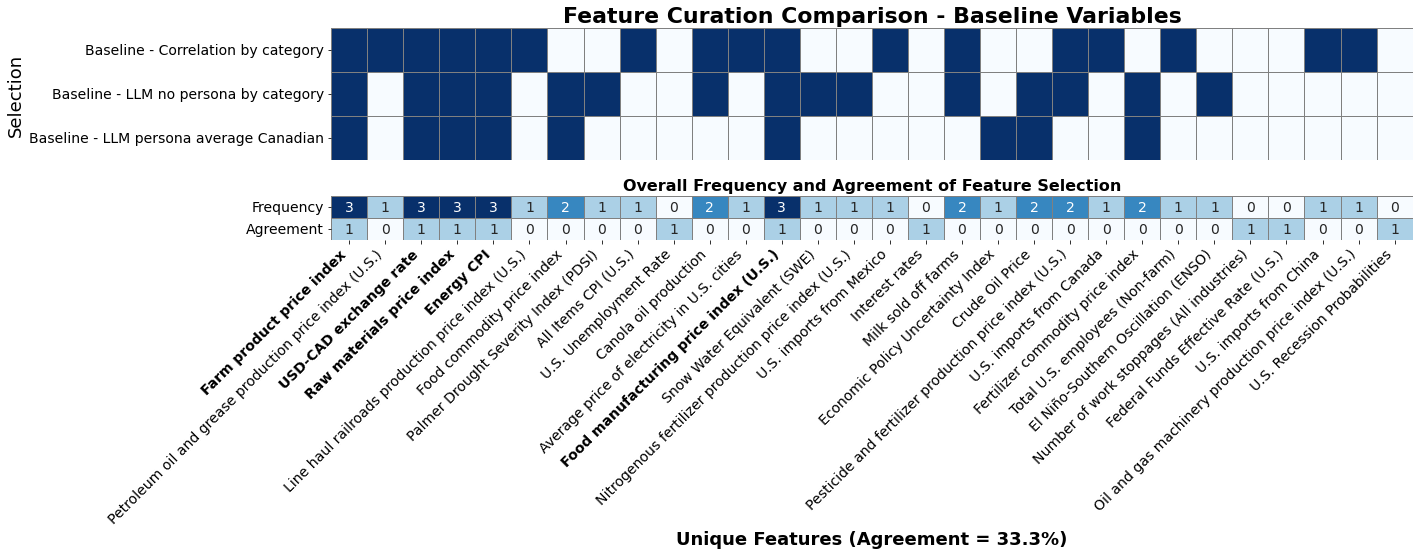

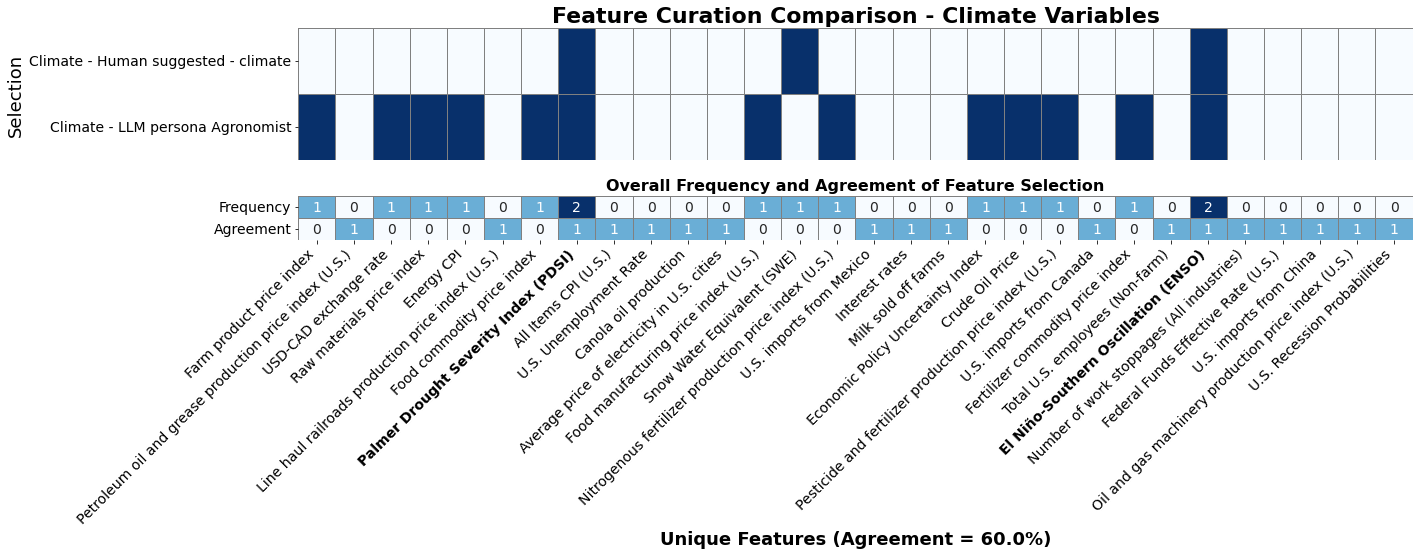

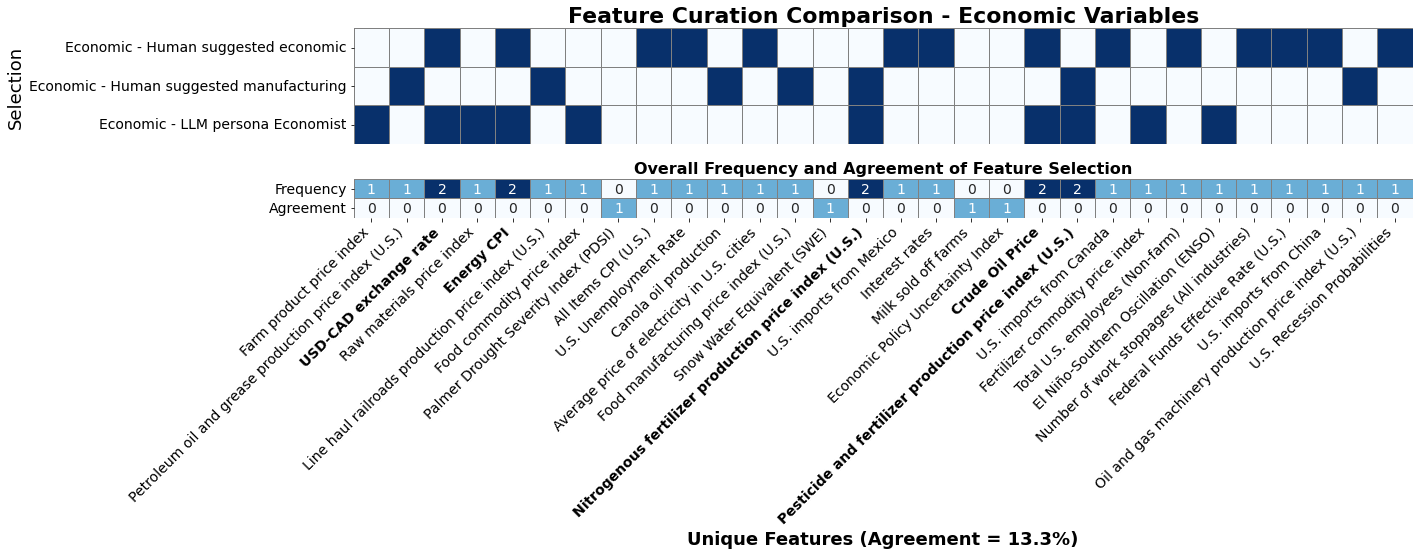

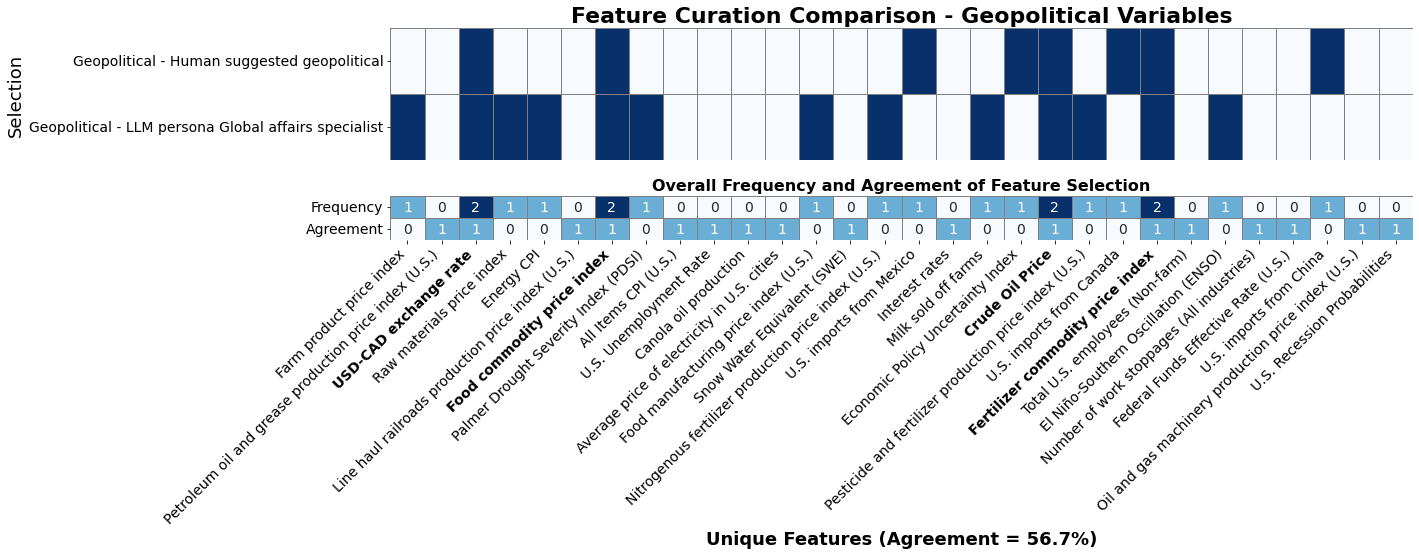

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set general font properties for readability
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

# Loop over each group to create a combined heatmap per group
for group in df['group'].unique():
    # Filter the DataFrame for the specific group
    filtered_df = df[df['group'] == group].reset_index(drop=True)
    
    # Populate the dictionary: group features by selection and set 1 if used in the experiment
    group_feature_matrix_dict = {}
    for selection in filtered_df['selection'].unique():
        selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
        group_feature_matrix_dict[selection] = [1 if feature in selection_features else 0 for feature in unique_features]
    
    # Convert to DataFrame for heatmap plotting
    feature_matrix = pd.DataFrame(group_feature_matrix_dict, index=unique_features)
    
    # Rename rows for readability based on the column_mapping dictionary
    feature_matrix.rename(index=column_mapping, inplace=True)
    
    # Calculate frequency of each feature for the second heatmap
    feature_counts = feature_matrix.sum(axis=1)
    feature_count_df = pd.DataFrame(feature_counts, columns=['Frequency'])

    # Calculate agreement: 1 for complete agreement, 0 for partial agreement
    agreement_score = feature_matrix.apply(lambda row: 1 if row.nunique() == 1 else 0, axis=1)
    feature_count_df['Agreement'] = agreement_score

    # Calculate the percentage of rows with full agreement (1) vs partial agreement (0)
    agreement_percentage = (agreement_score.sum() / len(agreement_score)) * 100

    # Identify the maximum frequency to bold corresponding x labels
    max_frequency = feature_count_df['Frequency'].max()

    # Set up a combined figure with vertically stacked heatmaps
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Heatmap 1: Feature Usage by Selection (Blue color scale) - without color bar
    sns.heatmap(
        feature_matrix.T, 
        cmap="Blues", 
        linewidths=0.5, 
        linecolor='grey', 
        annot=False, 
        cbar=False,  # Remove color bar
        ax=ax1
    )
    ax1.set_title(f"Feature Curation Comparison - {group} Variables", fontsize=22, weight='bold')
    ax1.set_xlabel("")  # Remove x-axis label for upper heatmap
    ax1.set_ylabel("Selection", fontsize=18)
    ax1.tick_params(axis='x', bottom=False)  # Hide x-tick marks
    ax1.set_xticklabels([])  # Remove x-tick labels

    # Heatmap 2: Frequency and Agreement of Feature Usage (Blue color scale) - without color bar
    sns.heatmap(
        feature_count_df.T, 
        cmap="Blues", 
        linewidths=0.5, 
        linecolor='grey', 
        annot=True, 
        fmt="d", 
        annot_kws={'size': 14}, 
        cbar=False,  # Remove color bar
        ax=ax2
    )
    ax2.set_title("Overall Frequency and Agreement of Feature Selection", fontsize=16, weight='bold')
    ax2.set_xlabel(f"Unique Features (Agreement = {agreement_percentage:.1f}%)", fontsize=18, weight='bold')
    ax2.set_ylabel("")  # Remove y-axis label for lower heatmap
    ax2.tick_params(axis='x', rotation=45, labelsize=14)

    # Adjust x-axis tick alignment with heatmap boxes
    x_labels = feature_count_df.index
    ax2.set_xticks([x + 0.5 for x in range(len(x_labels))])  # Shift ticks to center
    ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

    # Bold x-axis labels with maximum frequency
    for label, frequency, tick in zip(x_labels, feature_count_df['Frequency'], ax2.get_xticklabels()):
        if frequency == max_frequency:
            tick.set_fontweight('bold')  # Bold only the labels with max frequency

    plt.tight_layout()
    plt.savefig(f'Fig65_{group}.pdf')

    plt.show()


### Check LLM agreement

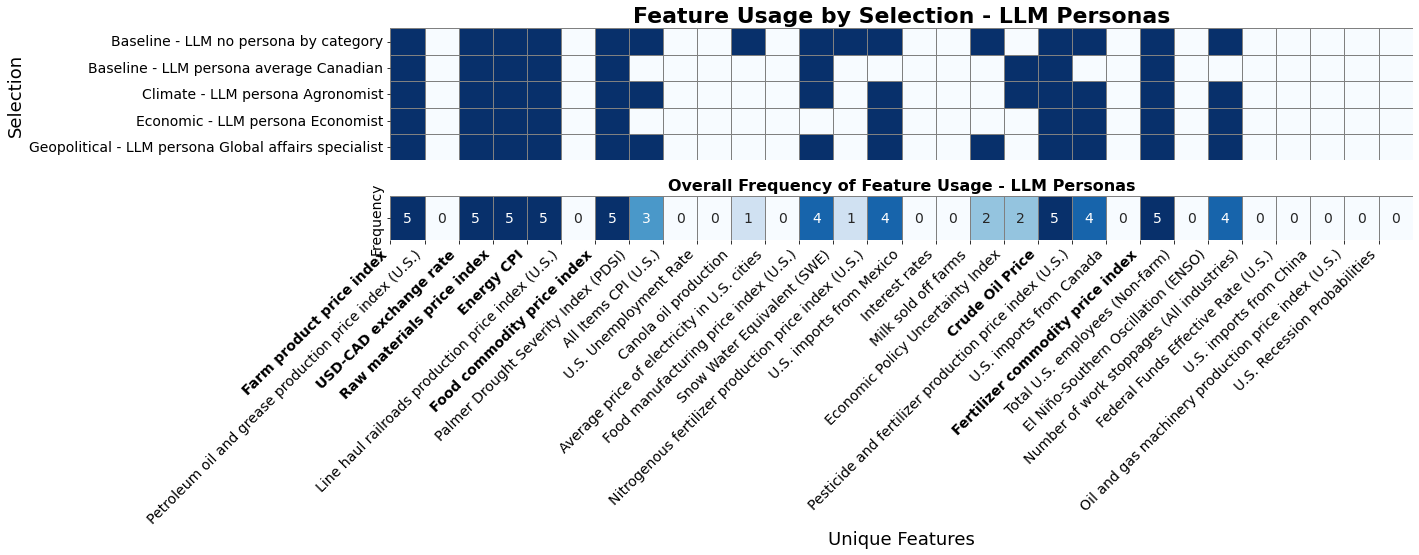

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set general font properties for readability
plt.rcParams.update({
    'font.size': 16,  # General font size
    'axes.titlesize': 22,  # Title font size
    'axes.labelsize': 18,  # Axis label font size
    'xtick.labelsize': 14,  # X-tick label font size
    'ytick.labelsize': 14,  # Y-tick label font size
})

# Filter the DataFrame for rows where 'selection' contains "LLM"
filtered_df = df[df['selection'].str.contains("LLM", case=False)].reset_index(drop=True)

# Initialize an empty dictionary to collect feature usage by selection
feature_matrix_dict = {}

# Populate the dictionary: group features by selection and set 1 if used in the experiment
for selection in filtered_df['selection'].unique():
    selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
    feature_matrix_dict[selection] = [1 if feature in selection_features else 0 for feature in unique_features]

# Convert to DataFrame for heatmap plotting
feature_matrix = pd.DataFrame(feature_matrix_dict, index=unique_features)

# Rename rows for readability based on the column_mapping dictionary
feature_matrix.rename(index=column_mapping, inplace=True)

# Calculate frequency of each feature for the second heatmap
feature_counts = feature_matrix.sum(axis=1)
feature_count_df = pd.DataFrame(feature_counts, columns=['Frequency'])

# Find the maximum frequency
max_frequency = feature_count_df['Frequency'].max()

# Set up a combined figure with vertically stacked heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]})

# Heatmap 1: Feature Usage by Selection (Blue color scale) - without color bar
sns.heatmap(
    feature_matrix.T, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor='grey', 
    annot=False, 
    cbar=False,  # Remove color bar
    ax=ax1
)
ax1.set_title("Feature Usage by Selection - LLM Personas", fontsize=22, weight='bold')
ax1.set_xlabel("")  # Remove x-axis label for upper heatmap
ax1.set_ylabel("Selection", fontsize=18)
ax1.tick_params(axis='x', bottom=False)  # Hide x-tick marks
ax1.set_xticklabels([])  # Remove x-tick labels

# Heatmap 2: Frequency of Feature Usage (Green color scale) - without color bar
sns.heatmap(
    feature_count_df.T, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor='grey', 
    annot=True, 
    fmt="d", 
    annot_kws={'size': 14}, 
    cbar=False,  # Remove color bar
    ax=ax2
)
ax2.set_title("Overall Frequency of Feature Usage - LLM Personas", fontsize=16, weight='bold')
ax2.set_xlabel("Unique Features", fontsize=18)
ax2.set_ylabel("")  # Remove y-axis label for lower heatmap
ax2.tick_params(axis='x', rotation=45, labelsize=14)

# Bold x-tick labels where frequency is maximum
x_labels = feature_count_df.index
ax2.set_xticks(range(len(x_labels)))  # Ensure tick positions align
ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# Apply bold font weight to labels with maximum frequency
for label, frequency, tick in zip(x_labels, feature_count_df['Frequency'], ax2.get_xticklabels()):
    if frequency == max_frequency:
        tick.set_fontweight('bold')  # Bold only the labels with max frequency

plt.tight_layout()
plt.show()


## Create a plot to understand feature selection by target category 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set general font properties for readability
plt.rcParams.update({
    'font.size': 16,  # General font size
    'axes.titlesize': 22,  # Title font size
    'axes.labelsize': 18,  # Axis label font size
    'xtick.labelsize': 14,  # X-tick label font size
    'ytick.labelsize': 14,  # Y-tick label font size
})

# Define categories to compare
categories_compare = [
    'Bakery',
    'Fish',
    'Fruit',
    'Meat',
    'Vegetables',
    'Dairy'
]

# Mapping dictionary based on the provided table
column_mapping = {
    "policy_uncertainty": "Economic Policy Uncertainty Index",
    "apu000072610": "Average price of electricity in U.S. cities",
    "cwur0000sa0": "All Items CPI (U.S.)",
    "excaus": "USD-CAD exchange rate",
    "fedfunds": "Federal Funds Effective Rate (U.S.)",
    "fmpi": "Food manufacturing price index (U.S.)",
    "impca": "U.S. imports from Canada",
    "impch": "U.S. imports from China",
    "impmx": "U.S. imports from Mexico",
    "irltlt01cam156n": "Interest rates",
    "paynsa": "Total U.S. employees (Non-farm)",
    "pcu32533253": "Pesticide and fertilizer production price index (U.S.)",
    "pcu324191324191": "Petroleum oil and grease production price index (U.S.)",
    "pcu325311325311": "Nitrogenous fertilizer production price index (U.S.)",
    "pcu333132333132": "Oil and gas machinery production price index (U.S.)",
    "pcu482111482111": "Line haul railroads production price index (U.S.)",
    "recprousm156n": "U.S. Recession Probabilities",
    "unratensa": "U.S. Unemployment Rate",
    "wtisplc": "Crude Oil Price",
    "enso": "El Niño-Southern Oscillation (ENSO)",
    "canola_oil": "Canola oil production",
    "energy_cpi": "Energy CPI",
    "swe_total": "Snow Water Equivalent (SWE)",
    "pdsi_total": "Palmer Drought Severity Index (PDSI)",
    "fppi_total": "Farm product price index",
    "milk_sold_total": "Milk sold off farms",
    "work_stop_total": "Number of work stoppages (All industries)",
    "rmpi_total": "Raw materials price index",
    "commodity_food": "Food commodity price index",
    "commodity_fertilizer": "Fertilizer commodity price index"
}

# Loop through each category to create heatmaps and compile frequency data
for category in categories_compare:
    # Filter DataFrame to include both specific category and general category rows
    filtered_df = df[(df['category'] == category) | (df['category'] == 'General - Non category specific')].reset_index(drop=True)
    
    # Initialize an empty dictionary to collect feature usage by selection
    feature_matrix_dict = {}

    # Populate the dictionary: group features by selection and set 1 if used in the experiment
    for selection in filtered_df['selection'].unique():
        selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
        feature_matrix_dict[selection] = [1 if feature in selection_features else 0 for feature in unique_features]

    # Convert to DataFrame for the current category
    feature_matrix = pd.DataFrame(feature_matrix_dict, index=unique_features)
    
    # Rename columns and index based on the column_mapping dictionary
    feature_matrix.rename(index=column_mapping, inplace=True)

    # Calculate the frequency of each feature for the second heatmap
    feature_counts = feature_matrix.sum(axis=1)
    feature_count_df = pd.DataFrame(feature_counts, columns=['Frequency'])

    # Find the top 2 distinct maximum frequencies
    sorted_frequencies = feature_count_df['Frequency'].sort_values(ascending=False).unique()
    if len(sorted_frequencies) > 1:
        top_2_frequencies = sorted_frequencies[:2]
    else:
        top_2_frequencies = sorted_frequencies  # If only one unique frequency, take it as top

    # Set up a combined figure with vertically stacked heatmaps
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,11), gridspec_kw={'height_ratios': [9, 1]})

    # Heatmap 1: Feature Usage by Selection (Blue color scale)
    sns.heatmap(
        feature_matrix.T, 
        cmap="Blues", 
        linewidths=0.5, 
        linecolor='grey', 
        annot=False, 
        cbar=False,  # Remove color bar
        ax=ax1
    )
    ax1.set_title(f"Feature Usage by Selection for {category} Category", fontsize=22, weight='bold')
    ax1.set_xlabel("")  # Remove x-axis label for upper heatmap
    ax1.set_ylabel("Selection", fontsize=18)
    ax1.tick_params(axis='x', bottom=False)  # Hide x-tick marks
    ax1.set_xticklabels([])  # Remove x-tick labels

    # Heatmap 2: Frequency of Feature Usage (Green color scale)
    sns.heatmap(
        feature_count_df.T, 
        cmap="Blues", 
        linewidths=0.5, 
        linecolor='grey', 
        annot=True, 
        fmt="d", 
        annot_kws={'size': 14}, 
        cbar=False,  # Remove color bar
        ax=ax2
    )
    ax2.set_title("Overall Frequency of Feature Usage", fontsize=16, weight='bold')
    ax2.set_xlabel("Unique Features", fontsize=18)
    ax2.set_ylabel("")  # Remove y-axis label for lower heatmap
    ax2.tick_params(axis='x', rotation=45, labelsize=14)

    # Bold x-tick labels for the top 2 frequencies
    x_labels = feature_count_df.index
    ax2.set_xticks(range(len(x_labels)))  # Ensure tick positions align
    ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

    # Apply bold font weight to labels with the top 2 maximum frequencies
    for label, frequency, tick in zip(x_labels, feature_count_df['Frequency'], ax2.get_xticklabels()):
        if frequency in top_2_frequencies:
            tick.set_fontweight('bold')  # Bold only the labels with the top 2 frequencies

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your main DataFrame and 'unique_features' is the list of all unique features
# Define categories to compare
categories_compare = [
    'Bakery',
    'Fish',
    'Fruit',
    'Meat',
    'Vegetables',
    'Dairy'
]

# Mapping dictionary based on the provided table
column_mapping = {
    "policy_uncertainty": "Economic Policy Uncertainty Index",
    "apu000072610": "Average price of electricity in U.S. cities",
    "cwur0000sa0": "All Items CPI (U.S.)",
    "excaus": "USD-CAD exchange rate",
    "fedfunds": "Federal Funds Effective Rate (U.S.)",
    "fmpi": "Food manufacturing price index (U.S.)",
    "impca": "U.S. imports from Canada",
    "impch": "U.S. imports from China",
    "impmx": "U.S. imports from Mexico",
    "irltlt01cam156n": "Interest rates",
    "paynsa": "Total U.S. employees (Non-farm)",
    "pcu32533253": "Pesticide and fertilizer production price index (U.S.)",
    "pcu324191324191": "Petroleum oil and grease production price index (U.S.)",
    "pcu325311325311": "Nitrogenous fertilizer production price index (U.S.)",
    "pcu333132333132": "Oil and gas machinery production price index (U.S.)",
    "pcu482111482111": "Line haul railroads production price index (U.S.)",
    "recprousm156n": "U.S. Recession Probabilities",
    "unratensa": "U.S. Unemployment Rate",
    "wtisplc": "Crude Oil Price",
    "enso": "El Niño-Southern Oscillation (ENSO)",
    "canola_oil": "Canola oil production",
    "energy_cpi": "Energy CPI",
    "swe_total": "Snow Water Equivalent (SWE)",
    "pdsi_total": "Palmer Drought Severity Index (PDSI)",
    "fppi_total": "Farm product price index",
    "milk_sold_total": "Milk sold off farms",
    "work_stop_total": "Number of work stoppages (All industries)",
    "rmpi_total": "Raw materials price index",
    "commodity_food": "Food commodity price index",
    "commodity_fertilizer": "Fertilizer commodity price index"
}

# Initialize an empty DataFrame to compile the summary frequency table
summary_frequency_df = pd.DataFrame(0, index=unique_features, columns=categories_compare)

# Loop through each category to create heatmaps and compile frequency data
for category in categories_compare:
    # Filter DataFrame to include both specific category and general category rows
    filtered_df = df[(df['category'] == category) | (df['category'] == 'General - Non category specific')].reset_index(drop=True)
    
    # Initialize an empty dictionary to collect feature usage by selection
    feature_matrix_dict = {}

    # Populate the dictionary: group features by selection and set 1 if used in the experiment
    for selection in filtered_df['selection'].unique():
        selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
        feature_matrix_dict[selection] = [1 if feature in selection_features else 0 for feature in unique_features]

    # Convert to DataFrame for the current category
    feature_matrix = pd.DataFrame(feature_matrix_dict, index=unique_features)
    
    # Rename columns and index based on the column_mapping dictionary
    feature_matrix.rename(index=column_mapping, inplace=True)

    # Plotting the heatmap for the current category
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        feature_matrix.T, 
        cmap="Blues", 
        cbar_kws={'label': 'Feature Presence'}, 
        linewidths=0.5, 
        linecolor='grey', 
        annot=True, 
        fmt="d", 
        annot_kws={'size': 8}
    )
    plt.title(f"Feature Selection Frequency for {category} Category")
    plt.xlabel("Unique Features")
    plt.ylabel("Selection")
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your main DataFrame and 'unique_features' is the list of all unique features
# Define categories to compare
categories_compare = [
    'Bakery',
    'Fish',
    'Fruit',
    'Meat',
    'Vegetables',
    'Dairy'
]

# Initialize an empty DataFrame to accumulate the counts
aggregate_feature_matrix = pd.DataFrame(0, index=unique_features, columns=df['selection'].unique())

# Loop through each category and accumulate feature counts by selection method
for category in categories_compare:
    # Filter DataFrame to include both specific category and general category rows
    filtered_df = df[(df['category'] == category) | (df['category'] == 'General - Non category specific')].reset_index(drop=True)
    
    # Loop through each selection method within the filtered DataFrame
    for selection in filtered_df['selection'].unique():
        # Get the features used for this selection within this category
        selection_features = set(filtered_df[filtered_df['selection'] == selection]['features_used'].sum())
        
        # Increment the count for each feature in the aggregate matrix
        for feature in selection_features:
            if feature in aggregate_feature_matrix.index:
                aggregate_feature_matrix.at[feature, selection] += 1

# Rename the index of aggregate_feature_matrix for readability
aggregate_feature_matrix.rename(index=column_mapping, inplace=True)

# Plotting the aggregate heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    aggregate_feature_matrix.T, 
    cmap="Blues",  # Use reversed yellow-green colormap for darker values on higher counts
    cbar_kws={'label': 'Number of Categories with Feature Presence'}, 
    linewidths=0.5, 
    linecolor='grey', 
    annot=True, 
    fmt="d",  # Display count in each cell
    annot_kws={'size': 8}
)
plt.title("Feature Selection Frequency by Selection Technique (Presence Across All Food Categories)")
plt.xlabel("Features")
plt.ylabel("Selection Techniques")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
